# Look at the overview scans
Let's see what we did there.

In [1]:
import platform
import glob
import os
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.patches
import seaborn
import pandas
import numpy
from tqdm import notebook
from itkwidgets import view  # 3d viewer
import imageio
import dask
import dask.array as da
import dask_image.imread
from distributed import Client
client = Client(processes=False,
                local_directory='',
#                 n_workers=32,
#                 silence_logs=True
               )
# Then go to http://localhost:8787/status
from numcodecs import Blosc


Failed to start diagnostics server on port 8787. [WinError 10048] Normalerweise darf jede Socketadresse (Protokoll, Netzwerkadresse oder Anschluss) nur jeweils einmal verwendet werden


In [3]:
print('You can seee what DASK is doing at "http://localhost:%s/status"' % client.scheduler_info()['services']['dashboard'])

You can seee what DASK is doing at "http://localhost:62029/status"


In [4]:
# # Ignore warnings in the notebook
# import warnings
# warnings.filterwarnings("ignore")

In [5]:
# Set up figure defaults
plt.rc('image', cmap='gray', interpolation='nearest')  # Display all images in b&w and with 'nearest' interpolation
plt.rcParams['figure.figsize'] = (16, 9)  # Size up figures a bit

In [6]:
# Setup scale bar defaults
plt.rcParams['scalebar.location'] = 'lower right'
plt.rcParams['scalebar.frameon'] = False
plt.rcParams['scalebar.color'] = 'white'

In [7]:
# Display all plots identically
lines = 4
# And then do something like
# plt.subplot(lines, numpy.ceil(len(Data) / float(lines)), c + 1)

In [8]:
# Different locations if running either on Linux or Windows
FastSSD = True
# to speed things up significantly
if 'Linux' in platform.system():
    if FastSSD:
        BasePath = os.path.join(os.sep, 'media', 'habi', 'Fast_SSD')
    else:
        BasePath = os.path.join(os.sep, 'home', 'habi', '1272')
else:
    if FastSSD:
        BasePath = os.path.join('F:\\')
    else:
        if 'anaklin' in platform.node():
            BasePath = os.path.join('S:\\')
        else:
            BasePath = os.path.join('D:\\Results')
Root = os.path.join(BasePath, 'Hearts Melly')
print('We are loading all the data from %s' % Root)

We are loading all the data from F:\Hearts Melly


In [9]:
def get_pixelsize(logfile):
    """Get the pixel size from the scan log file"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Image Pixel' in line and 'Scaled' not in line:
                pixelsize = float(line.split('=')[1])
    return(pixelsize)

In [10]:
# Make us a dataframe for saving all that we need
Data = pandas.DataFrame()

In [11]:
# Get all folders
Data['Folder'] = glob.glob(os.path.join(Root, 'Rat[67]*', '*'))

In [12]:
# Get rid of all non-folders
for c, i in Data.iterrows():
    if not os.path.isdir(i.Folder):
        Data.drop([c], inplace=True)
Data.reset_index(drop=True, inplace=True)

In [13]:
try:
    Data['Folder'][0]
except IndexError:
    print(10 * '\n')
    print('Please mount the Fast SSD!')
    print(10 * '\n')

In [14]:
Data['Sample'] = [os.path.basename(os.path.dirname(f)) for f in Data['Folder']]
Data['Scan'] = [os.path.basename(f) for f in Data['Folder']]
Data['SampleNameLength'] = [len(sn) for sn in Data['Sample']]
Data['ScanNameLength'] = [len(sn) for sn in Data['Scan']]

In [15]:
print('We performed %s scans' % len(Data))

We performed 5 scans


In [16]:
# Get log files of all the scans scans
Data['LogFile'] = [sorted(glob.glob(os.path.join(f, 'proj', '*.log')))[0] for f in Data['Folder']]

In [17]:
# Get voxelsize from logfiles
Data['Voxelsize'] = [get_pixelsize(log) for log in Data['LogFile']]

In [18]:
Data.head()

Folder Sample      Scan  SampleNameLength  \
0  F:\Hearts Melly\Rat60\overview  Rat60  overview                 5   
1  F:\Hearts Melly\Rat61\overview  Rat61  overview                 5   
2  F:\Hearts Melly\Rat62\overview  Rat62  overview                 5   
3  F:\Hearts Melly\Rat63\overview  Rat63  overview                 5   
4  F:\Hearts Melly\Rat64\overview  Rat64  overview                 5   

   ScanNameLength                                        LogFile  Voxelsize  
0               8  F:\Hearts Melly\Rat60\overview\proj\Rat60.log  10.000036  
1               8  F:\Hearts Melly\Rat61\overview\proj\Rat61.log  10.000036  
2               8  F:\Hearts Melly\Rat62\overview\proj\Rat62.log  10.000036  
3               8  F:\Hearts Melly\Rat63\overview\proj\Rat63.log  10.000036  
4               8  F:\Hearts Melly\Rat64\overview\proj\Rat64.log  10.000036

In [19]:
# Save to XLS sheet for Ludovic
Data[['Folder', 'Sample', 'Scan', 'Voxelsize']].to_excel('Voxelsizes.xlsx')

In [20]:
# Get the file names of the reconstructions
Data['Reconstructions'] = [sorted(glob.glob(os.path.join(f,
                                                         'rec',
                                                         '*.png'))) for f in Data['Folder']]
Data['Number of reconstructions'] = [len(r) for r in Data.Reconstructions]

In [21]:
# Display some info
for c, row in Data.iterrows():
    print('%02s/%s: %s has %03s reconstructions in %s/%s' % (c + 1,
                                                             len(Data),
                                                             row['Sample'].rjust(Data['SampleNameLength'].max()),
                                                             row['Number of reconstructions'],
                                                             os.path.basename(row['Folder']),
                                                             'rec'))

 1/5: Rat60 has 2795 reconstructions in overview/rec
 2/5: Rat61 has 2622 reconstructions in overview/rec
 3/5: Rat62 has 2853 reconstructions in overview/rec
 4/5: Rat63 has 2284 reconstructions in overview/rec
 5/5: Rat64 has 2401 reconstructions in overview/rec


In [22]:
# Convert all reconstructions into a DASK array and save them to disk
# Partially based on http://stackoverflow.com/a/39195332/323100
# and on /LungMetastasis/HighResolutionScanAnalysis.ipynb
Data['OutputNameRec'] = [os.path.join(f, sample + '_rec.zarr') for f, sample in zip(Data.Folder, Data.Sample)]
Reconstructions = [numpy.nan for file in Data['OutputNameRec']]
for c, row in Data.iterrows():
    if os.path.exists(row['OutputNameRec']):
        print('%2s/%s: Already saved to %s' % (c + 1,
                                               len(Data),
                                               row['OutputNameRec'][len(Root):]))
    else:
        print('%2s/%s: Reading %s reconstructions and saving to %s' % (c + 1,
                                                                       len(Data),
                                                                       row['Number of reconstructions'],
                                                                       row['OutputNameRec'][len(Root):]))
        Reconstructions = dask_image.imread.imread(os.path.join(row['Folder'], 'rec', '*.png'))
        Reconstructions.to_zarr(row['OutputNameRec'],
                                overwrite=True,
                                compressor=Blosc(cname='zstd',
                                                 clevel=3,
                                                 shuffle=Blosc.BITSHUFFLE))

 1/5: Already saved to \Rat60\overview\Rat60_rec.zarr
 2/5: Already saved to \Rat61\overview\Rat61_rec.zarr
 3/5: Already saved to \Rat62\overview\Rat62_rec.zarr
 4/5: Already saved to \Rat63\overview\Rat63_rec.zarr
 5/5: Already saved to \Rat64\overview\Rat64_rec.zarr


In [23]:
# Load the reconstructions a zarr arrays
Reconstructions = [dask.array.from_zarr(file) for file in Data['OutputNameRec']]

In [24]:
# How big are the datasets?
Data['Size'] = [numpy.shape(rec) for rec in Reconstructions]

In [25]:
Data[['Sample','Size']]

Sample                Size
0  Rat60  (2795, 2452, 2452)
1  Rat61  (2622, 2452, 2452)
2  Rat62  (2853, 2452, 2452)
3  Rat63  (2284, 2452, 2452)
4  Rat64  (2401, 2452, 2452)

In [26]:
# The three cardinal directions
directions = ['Axial', 'Sagittal', 'Coronal']

In [35]:
# Read or calculate the middle slices, put them into the dataframe and save them to disk
for d, direction in enumerate(directions):
    Data['Mid_' + direction] = [None] * len(Reconstructions)
for c, row in notebook.tqdm(Data.iterrows(), desc='Middle images', total=len(Data)):
    for d, direction in notebook.tqdm(enumerate(directions),
                                      desc=row['Sample'],
                                      leave=False,
                                      total=len(directions)):
        outfilepath = os.path.join(row['Folder'], '%s.Middle.%s.png' % (row['Sample'], direction))
        if os.path.exists(outfilepath):
            Data.at[c,'Mid_' + direction] = imageio.imread(outfilepath)
        else:
            # Generate requested axial view
            if 'Axial' in direction:
                Data.at[c,'Mid_' + direction] = Reconstructions[c][Data['Size'][c][0]//2].compute()
            if 'Sagittal' in direction:
                Data.at[c,'Mid_' + direction] = Reconstructions[c][:,Data['Size'][c][1]//2,:].compute()
            if 'Coronal' in direction:
                Data.at[c,'Mid_' + direction] = Reconstructions[c][:,:,Data['Size'][c][2]//2].compute()
            # Save the calculated 'direction' view to disk
            imageio.imwrite(outfilepath, (Data.at[c,'Mid_' + direction]))

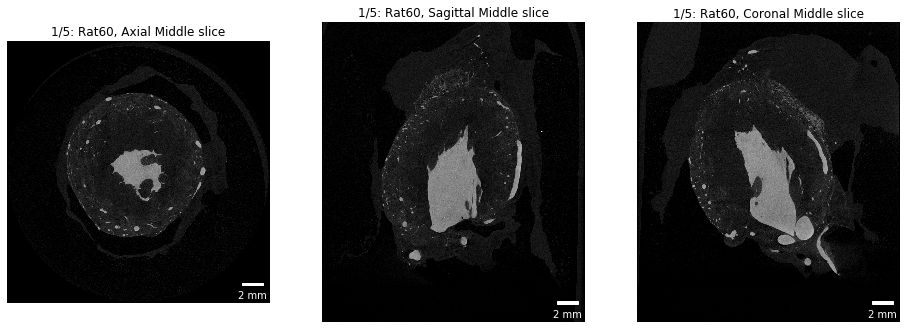

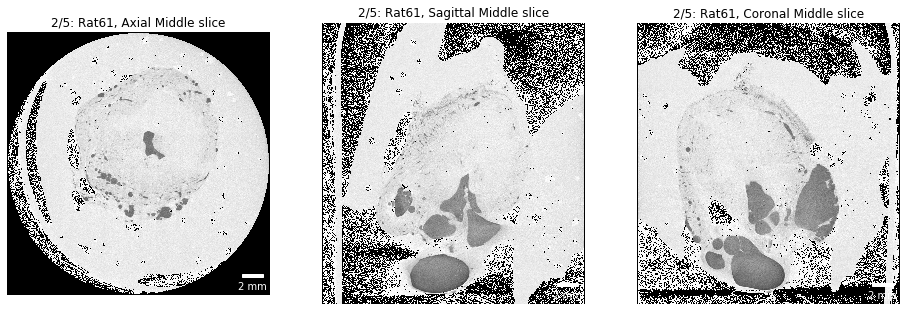

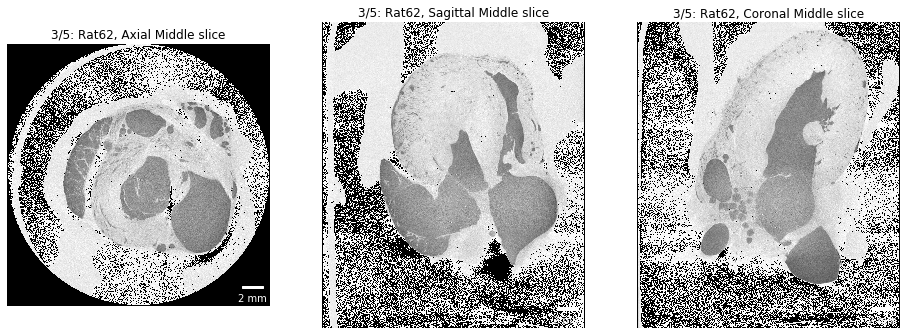

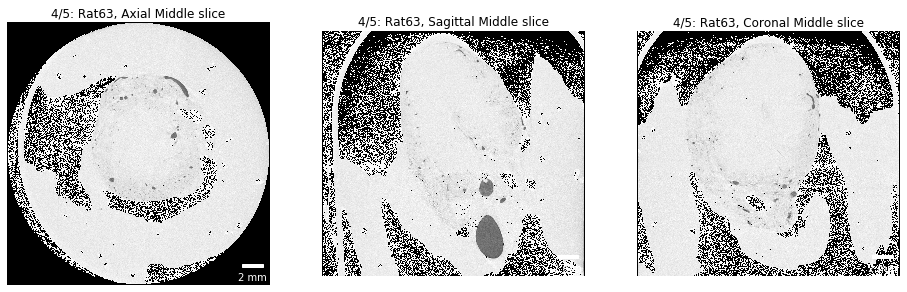

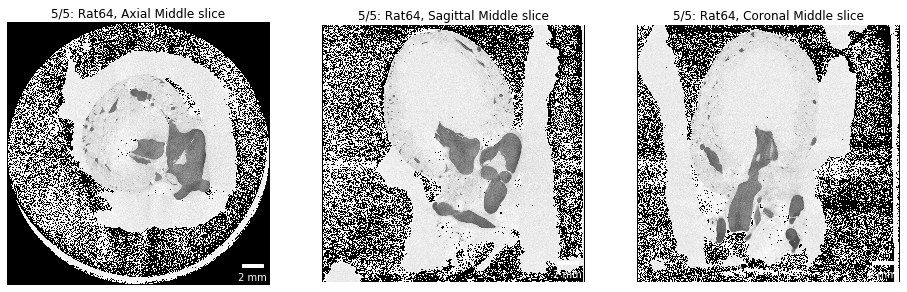

In [36]:
# Show middle slices
for c, row in Data.iterrows():
    for d, direction in enumerate(directions):
        plt.subplot(1, 3, d + 1)
        plt.imshow(row['Mid_' + direction])
        plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um'))
        plt.title('%s/%s: %s, %s' % (c + 1,
                                     len(Data),
                                     row['Sample'],
                                     direction + ' Middle slice'))
        plt.axis('off')
    plt.savefig(os.path.join(row['Folder'], row['Sample'] + '.MiddleSlices.png'),
                bbox_inches='tight')
    plt.show()

In [29]:
# Read or calculate the directional MIPs, put them into the dataframe and save them to disk
for d, direction in enumerate(directions):
    Data['MIP_' + direction] = [None] * len(Reconstructions)
for c, row in notebook.tqdm(Data.iterrows(), desc='MIPs', total=len(Data)):
    for d, direction in notebook.tqdm(enumerate(directions),
                                      desc=row['Sample'],
                                      leave=False,
                                      total=len(directions)):
        outfilepath = os.path.join(row['Folder'], '%s.MIP.%s.png' % (row['Sample'], direction))
        if os.path.exists(outfilepath):
            Data.at[c,'MIP_' + direction] = imageio.imread(outfilepath)
        else:
            # Generate MIP
            Data.at[c,'MIP_' + direction] = Reconstructions[c].max(axis=d).compute()
            # Save it out
            imageio.imwrite(outfilepath, Data.at[c,'MIP_' + direction].astype('uint8'))

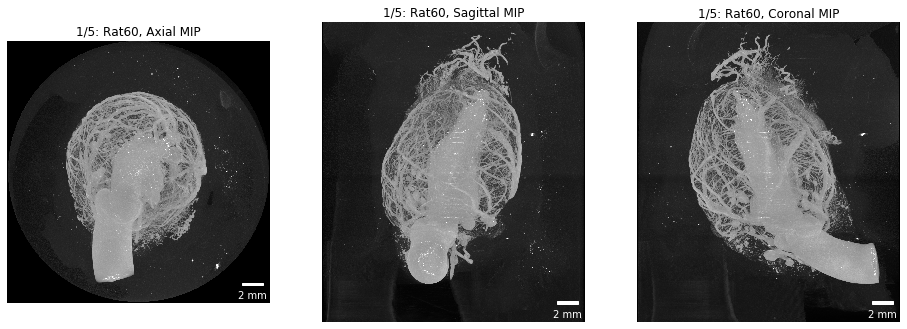

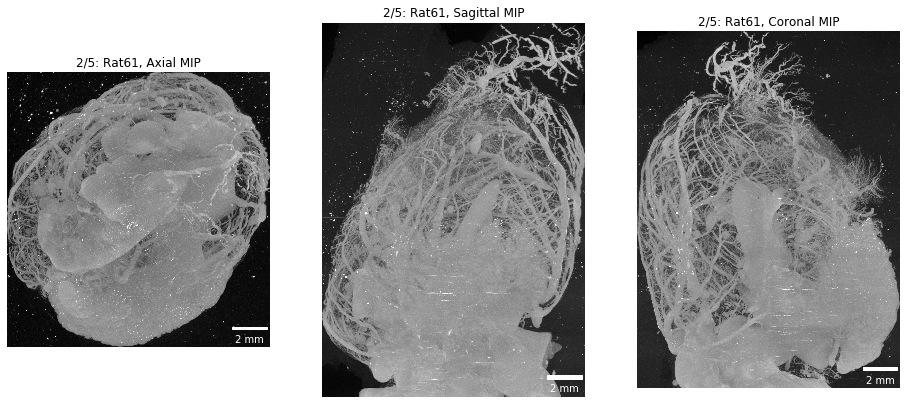

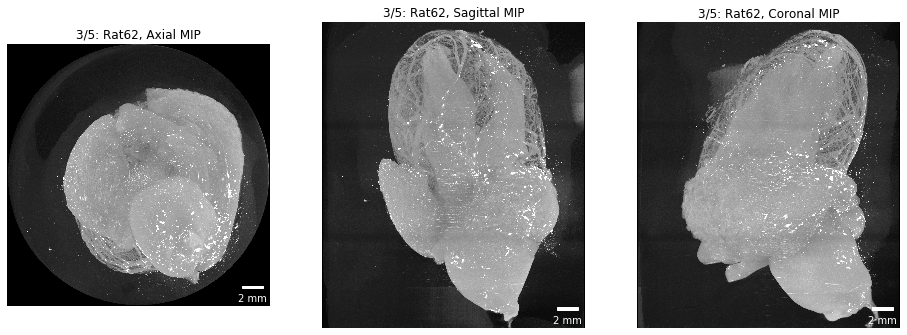

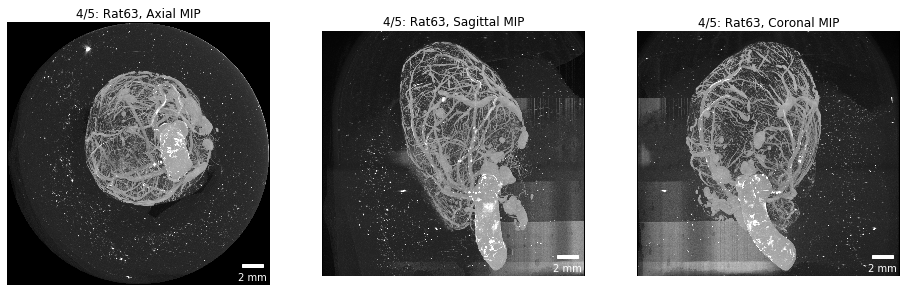

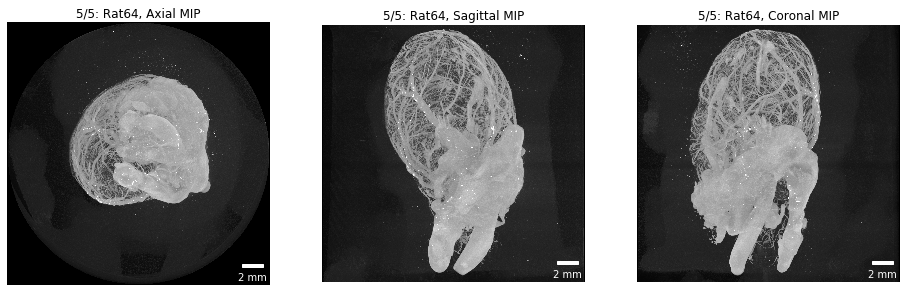

In [30]:
# Show MIP slices
for c, row in Data.iterrows():
    for d, direction in enumerate(directions):
        plt.subplot(1, 3, d + 1)
        plt.imshow(row['MIP_' + direction])
        plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um'))
        plt.title('%s/%s: %s, %s' % (c + 1,
                                     len(Data),
                                     row['Sample'],
                                     direction + ' MIP'))
        plt.axis('off')
    plt.savefig(os.path.join(row['Folder'], row['Sample'] + '.MIPs.png'),
                bbox_inches='tight')
    plt.show()

In [31]:
#for c, row in Data.iterrows():
#    for d, direction in enumerate(directions):
#        print(row.Sample, direction, numpy.mean(row['Mid_' + direction]))

Axial


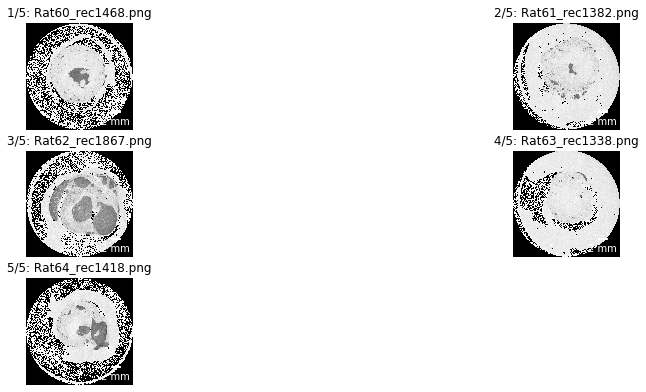

Sagittal


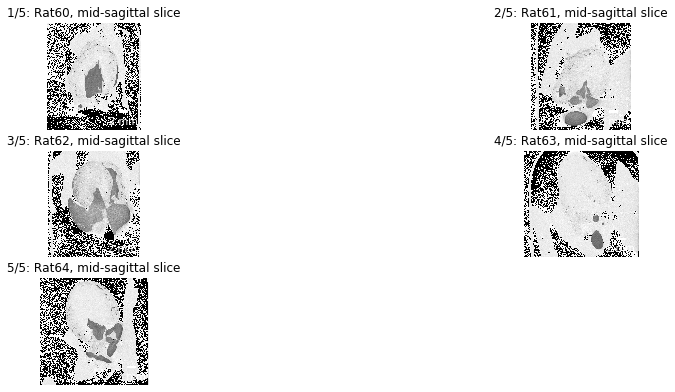

Coronal


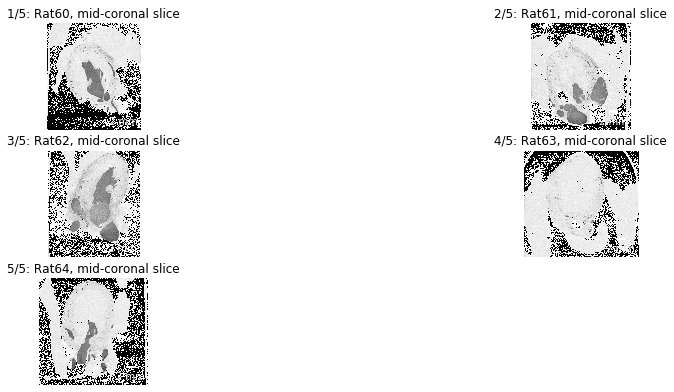

In [32]:
# Show middle slices together
for d, direction in enumerate(directions):
    print(direction)
    for c, row in Data.iterrows():
        plt.subplot(lines, numpy.ceil(len(Data) / float(lines)), c + 1)
        plt.imshow(row['Mid_' + direction])
        plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um'))
        if 'xial' in direction:
            recname = os.path.basename(row['Reconstructions'][row['Number of reconstructions'] // 2]).replace('0000',
                                                                                                              '')
            plt.title('%s/%s: %s' % (c + 1,
                                     len(Data),
                                     recname))
        else:
            plt.title('%s/%s: %s, mid-%s slice' % (c + 1,
                                                   len(Data),
                                                   row['Sample'],
                                                   direction.lower()))
        plt.axis('off')
    plt.savefig(os.path.join(Root, 'MiddleSlices.' + direction + '.png'),
                bbox_inches='tight')
    plt.show()

Axial


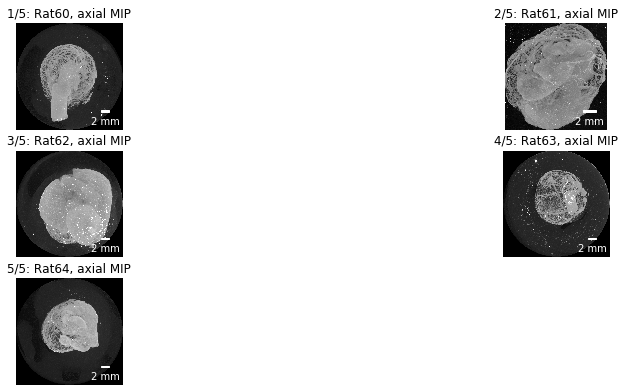

Sagittal


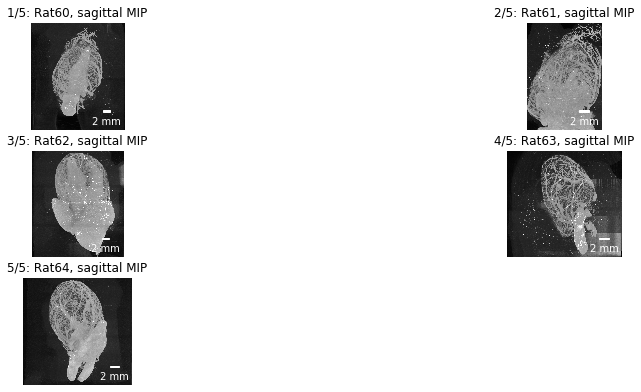

Coronal


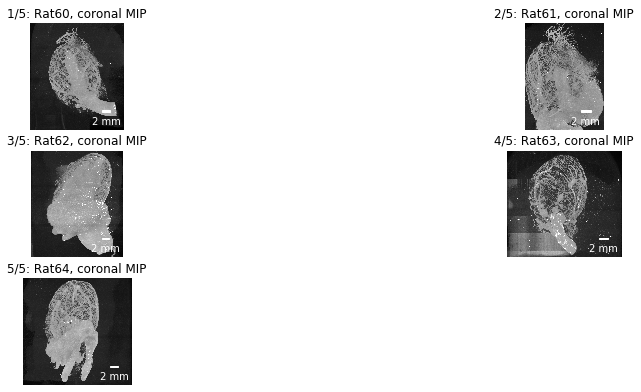

In [33]:
# Show MIPs together
for d, direction in enumerate(directions):
    print(direction)
    for c, row in Data.iterrows():
        plt.subplot(lines, numpy.ceil(len(Data) / float(lines)), c + 1)
        plt.imshow(row['MIP_' + direction])
        plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um'))
        plt.title('%s/%s: %s, %s MIP' % (c + 1,
                                         len(Data),
                                         row['Sample'],
                                         direction.lower()))
        plt.axis('off')
        plt.savefig(os.path.join(Root, 'MIPs.' + direction + '.png'),
                    bbox_inches='tight')
    plt.show()

In [34]:
# Save mean of reconstruction gray values, which we can use for getting an overview of the image data
Data['GrayValueMean'] = [rec.mean().compute() for rec in Reconstructions]

KeyboardInterrupt: 

In [ ]:
# Save STD of reconstruction gray values, which we can use for getting an overview of the image data
Data['GrayValueSTD'] = [rec.std().compute() for rec in Reconstructions]

In [ ]:
# Save out the dataframe to disk, so we can use it later in another notebook
Data.to_pickle(os.path.join(Root, 'MellyDataframe.pkl'))

In [42]:
#view(Reconstructions[2],
#     annotations=False)